<a href="https://colab.research.google.com/github/dogukartal/DCMotorCascadePIDControl/blob/main/Computer%20Vision/Hugging%20Face/0_CNNs.ipynb/1_2_Vision_Transformers_Multi_Label_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uq transformers datasets timm accelerate evaluate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

from pathlib import Path
from PIL import Image

import datasets

from transformers.optimization import get_cosine_schedule_with_warmup

from timm import list_models, create_model

from accelerate import Accelerator, notebook_launcher

import evaluate

dataset = datasets.load_dataset('fuliucansheng/pascal_voc','voc2007_main')

In [ ]:
class_names = [
    "Aeroplane","Bicycle","Bird","Boat","Bottle",
    "Bus","Car","Cat","Chair","Cow","Diningtable",
    "Dog","Horse","Motorbike","Person",
    "Potted plant","Sheep","Sofa","Train","Tv/monitor"
]

label2id = {c:idx for idx,c in enumerate(class_names)}
id2label = {idx:c for idx,c in enumerate(class_names)}

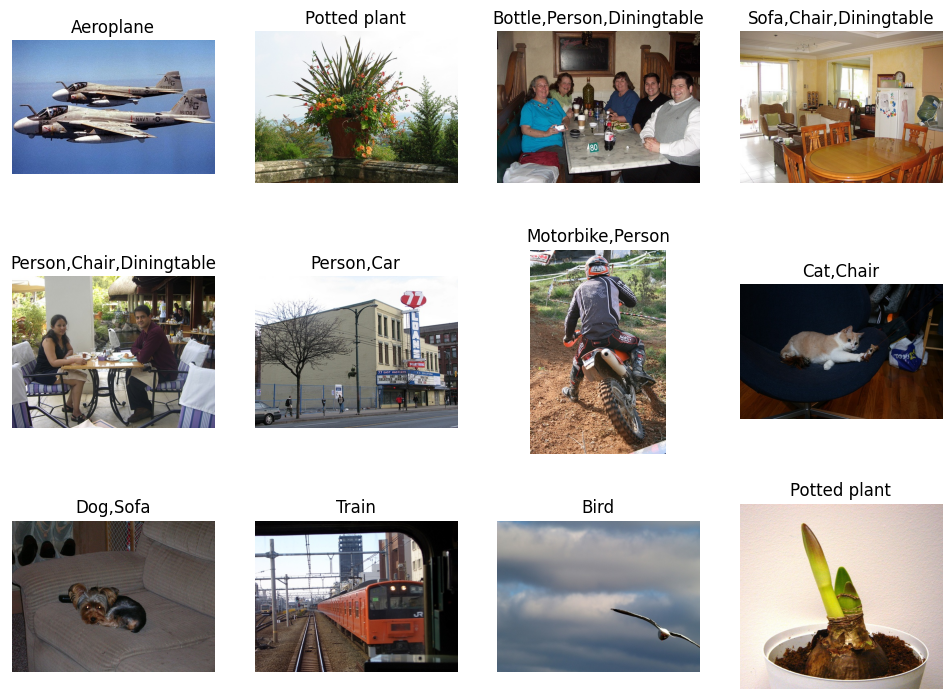

In [ ]:
def show_samples(dataset, rows, columns):
    samples = dataset.shuffle().select(np.arange(rows*columns))
    fig = plt.figure(figsize=(columns*3, rows*3))
    for i in range(rows*columns):
        img = samples[i]['image']
        labels = samples[i]['classes']
        labels = ','.join([id2label[lb] for lb in labels])
        fig.add_subplot(rows,columns,i+1)
        plt.imshow(img)
        plt.title(labels)
        plt.axis('off')

show_samples(dataset['train'], rows=3, columns=4)

### Image Preprocessing
- Resize: The model name `swin_s3_base_224` indicates the image input size should be 224x224, so we'll resize accordingly.
- RandomHorizontalFlip: randomly flips samples horizontally.
- RandomRotation: rotates the images in a range, here (-30,+30) degrees.
- CenterCrop: crops about the center of the image
- ToTensor: converts the PIL image to a torch.Tensor with channels-first order and scales to [0,1] range.
- Normalize: normalizes the tensor with provided mean and std. For Vision Transformers, the general mean and std used is (0.5,0.5,0.5), so we'll go with that.


### Label Preprocessing

```
label: [3,5], num_labels = 10
one-hot encoded label: [0 0 0 1 0 1 0 0 0 0]
```

```py
>>> sample_batch = [[2,14]]
>>> labels = torch.tensor(sample_batch) #tensor([[ 2, 14]])
>>> labels = nn.functional.one_hot(labels, num_classes=20) #tensor([[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]])     
>>> labels = labels.sum(dim=1) # tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
```

> When we apply this one-hot encoding, we are essentially converting this problem into a binary classification problem for each label.

In [ ]:
def train_transforms(batch):
    batch["image"] = [x.convert("RGB") for x in batch["image"]]
    inputs = [train_tfms(x) for x in batch["image"]]
    batch["pixel_values"] = inputs

    labels = [torch.tensor(c) for c in batch['classes']]  # Each label list is turned into a tensor
    labels = [nn.functional.one_hot(l, num_classes=20).sum(dim=0) for l in labels]  # One-hot encode and sum across labels
    batch['labels'] = torch.stack(labels)  # Stack the resulting tensors

    return batch

def valid_transforms(batch):
    batch["image"] = [x.convert("RGB") for x in batch["image"]]
    inputs = [valid_tfms(x) for x in batch["image"]]
    batch["pixel_values"] = inputs

    labels = [torch.tensor(c) for c in batch['classes']]  # Each label list is turned into a tensor
    labels = [nn.functional.one_hot(l, num_classes=20).sum(dim=0) for l in labels]  # One-hot encode and sum across labels
    batch['labels'] = torch.stack(labels)  # Stack the resulting tensors

    return batch

img_size = (224, 224)

train_tfms = T.Compose([
    T.Resize(img_size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])

valid_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])

train_dataset = dataset["train"].with_transform(train_transforms) # Each time an item is accessed, the provided transformation train_transforms is applied
valid_dataset = dataset["validation"].with_transform(valid_transforms)
test_dataset = dataset["test"].with_transform(valid_transforms)

len(train_dataset), len(valid_dataset), len(test_dataset)

(2501, 2510, 4952)

In [ ]:
sample_batch = next(iter(torch.utils.data.DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn)))
print(sample_batch['pixel_values'].shape)  # Should be (batch_size, 3, 224, 224)
print(sample_batch['labels'].shape)  # Should be (batch_size, 20)

torch.Size([2, 3, 224, 224])
torch.Size([2, 20])


In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch]).float()
    }

def param_count(model):
    params = [(p.numel(),p.requires_grad) for p in model.parameters()]
    trainable = sum([count for count,trainable in params if trainable])
    total = sum([count for count,_ in params])
    frac = (trainable / total) * 100
    return total, trainable, frac


### Training Loop
* **Data Loaders**: To iterate over our datasets in batches, `torch.utils.data.DataLoader`
* **Loss Function**:  Since after one-hot encoding our labels, we'll be using `nn.BCEWithLogitsLoss()` which will take our predictions and targets of the shape `(batch, num_labels)`
* **Model**: The model loaded from the `timm` library.
*  **Optimizer, Scheduler**: Optimizer updates the weights of our model. We'll be using `get_cosine_schedule_with_warmup` from `transformers.optimization`. The learning rate increases gradually till `num_warmup_steps` and decays for the remaining steps with cosine annealing.
* **Metrics**: we'll calculate metrics using `evaluate` library. We will be using `roc_auc` metric for `multilabel` with `micro` averaging which will calculate the metrics globally. (https://huggingface.co/spaces/evaluate-metric/roc_auc).

### Accelerate
* Accelerate takes care of device placement of our data and model automatically. We pass our model, dataloaders, optimizer, scheduler via `accelerator.prepare` method. To calculate metrics, we need to gather our batches from all devices, hence we use `accelerator.gather_for_metrics` to do so. ([Docs](https://huggingface.co/docs/accelerate/index), [HF space](https://huggingface.co/spaces/hf-accelerate/accelerate_examples))

In [ ]:
def train(model_name, batch_size=16, epochs=1, lr=2e-4):

    # Accelerator
    accelerator = Accelerator()

    # Data Loaders
    train_dl = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = batch_size, # the batch_size will be per-device
        shuffle=True, #Shuffle is True only for training
        num_workers=4,  # The number of subprocesses which will be used to create our batches
        collate_fn=collate_fn
    )

    print(train_dl)

    valid_dl = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size = batch_size*2,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    test_dl = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = batch_size*2,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    # timm model
    model = create_model(
        model_name,
        pretrained = True,
        num_classes = 20
    ).to(accelerator.device) # device placement: accelerator.device

    total, trainable, frac = param_count(model)
    accelerator.print(f"{total = :,} | {trainable = :,} | {frac:.2f}%")

    # Loss, Optimizer, Scheduler
    loss_fn = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.02)

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps = int(0.1 * len(train_dl)),
        num_training_steps = len(train_dl)
    )

    model, optimizer, scheduler, train_dl, valid_dl, test_dl = accelerator.prepare(
        model, optimizer, scheduler, train_dl, valid_dl, test_dl
    )

    for epoch in range(1,epochs+1):

        model.train() # Set model to train

        train_metric = evaluate.load("roc_auc","multilabel") # Load metric

        running_loss = 0.

        for batch in train_dl:

            logits = model(batch['pixel_values'])

            loss = loss_fn(logits,batch['labels'])
            accelerator.backward(loss) # Backpropagation
            optimizer.step() # Update weights
            scheduler.step() # Update Learning Rate
            optimizer.zero_grad() # Set grad values to zero

            running_loss += loss.item() # Keep track of loss

            # Prepare for metrics
            logits, labels = accelerator.gather_for_metrics(
                (logits, batch['labels'])
            )
            train_metric.add_batch(references=labels, prediction_scores=logits)

        # Loss and metric over 1 epoch
        train_loss = running_loss / len(train_dl)
        train_roc_auc = train_metric.compute(average='micro')['roc_auc']

        accelerator.print(f"\n{epoch = }")
        accelerator.print(f"{train_loss = :.3f} | {train_roc_auc = :.3f}")

        # Validation loop

        model.eval() # Set model for evaluation

        running_loss = 0.
        valid_metric = evaluate.load('roc_auc','multilabel')

        for batch in valid_dl:

            with torch.no_grad():
                logits = model(batch['pixel_values'])

            loss = loss_fn(logits, batch['labels'])
            running_loss += loss.item()

            logits, labels = accelerator.gather_for_metrics(
                (logits, batch['labels'])
            )
            valid_metric.add_batch(references=labels, prediction_scores=logits)


        valid_loss = running_loss / len(valid_dl)
        valid_roc_auc = valid_metric.compute(average='micro')['roc_auc']

        accelerator.print(f"{valid_loss = :.3f} | {valid_roc_auc = :.3f}")

        # Save model
        accelerator.save_model(model, f'./{model_name}-pascal')


    # Testing loop after all epochs are over

    test_metric = evaluate.load('roc_auc','multilabel')

    for batch in test_dl:

        with torch.no_grad():
            logits = model(batch['pixel_values'])

        logits, labels = accelerator.gather_for_metrics(
            (logits, batch['labels'])
        )
        test_metric.add_batch(references=labels, prediction_scores=logits)

    test_roc_auc = test_metric.compute(average='micro')['roc_auc']

    accelerator.print(f"\n\nTEST AUROC: {test_roc_auc:.3f}")

In [ ]:
model_name = 'swin_s3_base_224'
notebook_launcher(train, (model_name,8,5,5e-5), num_processes = 2)

Launching training on one GPU.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


total = 70,372,142 | trainable = 70,372,142 | 100.00%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



epoch = 1
train_loss = 0.184 | train_roc_auc = 0.888


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


valid_loss = 0.091 | valid_roc_auc = 0.981


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



epoch = 2
train_loss = 0.083 | train_roc_auc = 0.982


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


valid_loss = 0.066 | valid_roc_auc = 0.987


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



epoch = 3
train_loss = 0.052 | train_roc_auc = 0.992


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


valid_loss = 0.052 | valid_roc_auc = 0.992


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



epoch = 4
train_loss = 0.044 | train_roc_auc = 0.994


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


valid_loss = 0.056 | valid_roc_auc = 0.990


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



epoch = 5
train_loss = 0.029 | train_roc_auc = 0.998


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


valid_loss = 0.049 | valid_roc_auc = 0.992


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()




TEST AUROC: 0.992


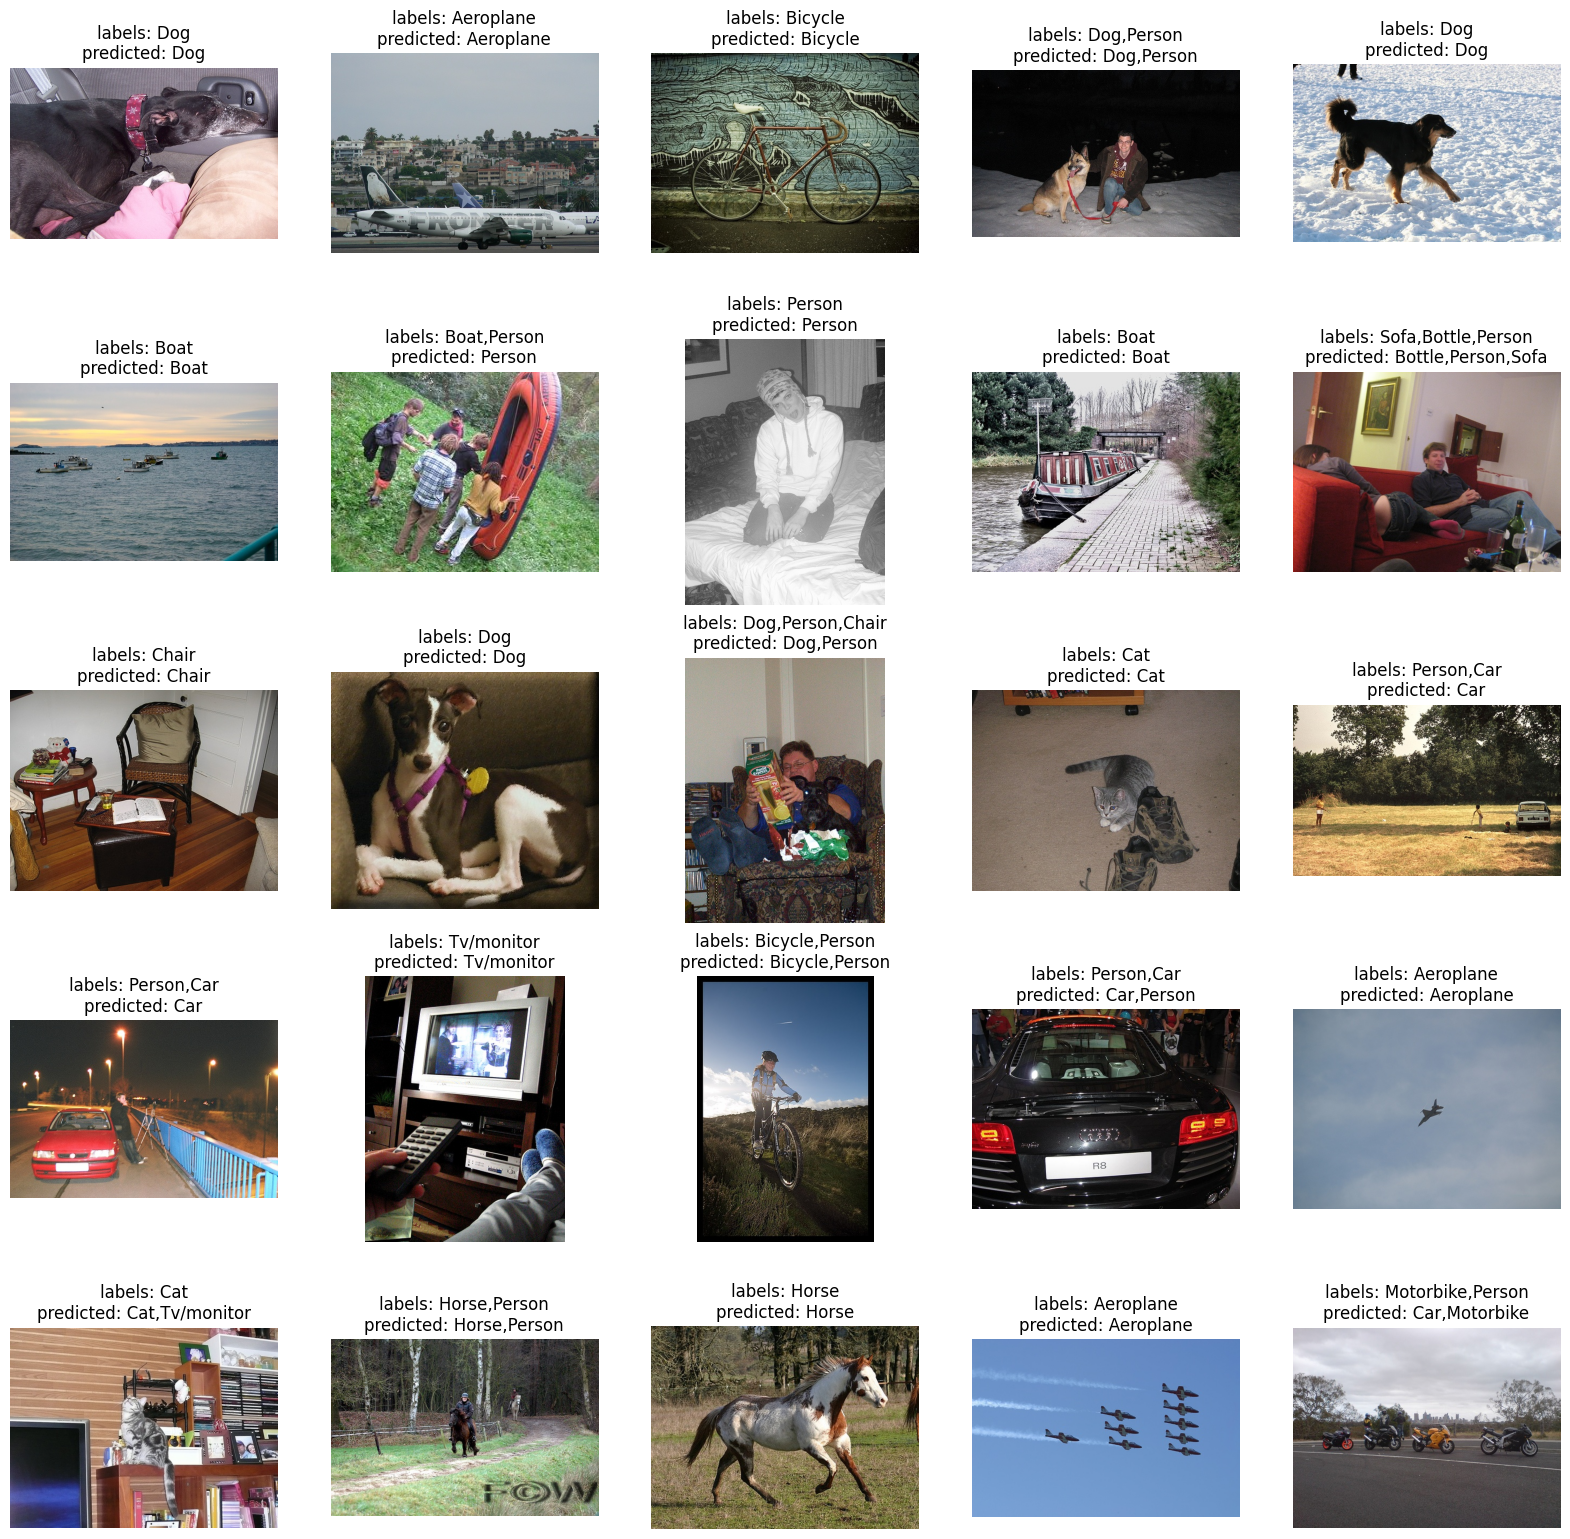

In [ ]:
from safetensors.torch import load_model

def show_predictions(rows=2,cols=4):
    model.eval()
    samples = test_dataset.shuffle().select(np.arange(rows*cols))
    fig = plt.figure(figsize=(cols*4,rows*4))

    for i in range(rows*cols):

        img = samples[i]['image']
        inputs = samples[i]['pixel_values'].unsqueeze(0)
        labels = samples[i]['classes']
        labels = ','.join([id2label[lb] for lb in labels])

        with torch.no_grad():
            logits = model(inputs)

        # apply sigmoid activation to convert logits to probabilities
        # getting labels with confidence threshold of 0.5
        predictions = logits.sigmoid() > 0.5

        # converting one-hot encoded predictions back to list of labels
        predictions = predictions.float().numpy().flatten() # convert boolean predictions to float
        pred_labels = np.where(predictions==1)[0] # find indices where prediction is 1
        pred_labels = ','.join([id2label[label] for label in pred_labels]) # converting integer labels to string

        label = f"labels: {labels}\npredicted: {pred_labels}"
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

model = create_model(
    model_name,
    num_classes=20
)

load_model(model,f'./{model_name}-pascal/model.safetensors')

show_predictions(rows=5,cols=5)